In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

In [2]:
import pymysql
from dotenv import load_dotenv
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
plt.rc('font', family = 'Hancom Gothic')

In [43]:
# 하이퍼파라미터
my_patience = 30
my_epochs = 1000
my_optimizer = Adam(learning_rate=0.00001)
my_batch_size = 100 # 작게 하면 더 미세하게 학습, 크게 하면 빠르고 덜 세밀

# 데이터 체크

In [4]:
load_dotenv()
host = os.getenv('host')
user = os.getenv('user')
password = os.getenv('password')
database = os.getenv('database')
port = int(os.getenv('port', 3306))

query =f"""
    SELECT *
    FROM basic_data"""

try:
    connection = pymysql.connect(
        host=host,
        user=user,
        password=password,
        database=database,
        port=port,
        charset='utf8mb4',
        cursorclass=pymysql.cursors.DictCursor
    )
    with connection.cursor() as cursor:
        cursor.execute(query)
        data = cursor.fetchall()
        whole_data = pd.DataFrame(data)
except Exception as e:
    print('에러 발생:', e)
finally:
    try:
        connection.close()
    except:
        pass

In [5]:
whole_data[whole_data['year']!=2025].isna().sum() # 학습에 사용할 데이터 : 21 ~ 24년 데이터, 결측치 X

year                0
month               0
day                 0
hour                0
district            0
datetime            0
total_population    0
season              0
commute_time        0
weekend_flag        0
precipitation       0
temperature         0
humidity            0
wind_speed          0
rental_count        0
dtype: int64

In [6]:
# PM데이터 로드
df_pm = pd.read_csv('PM_data/서울시_시간별_PM_배치_2021_2025.csv', parse_dates=['일시'])
df_pm.columns =['일시','행정구','PM대여량']

In [7]:
df_pm.isna().sum() # 결측치 0건

일시       0
행정구      0
PM대여량    0
dtype: int64

In [8]:
# def gu_change(row) :
#     row = row.copy()
#     if not row['행정구'].endswith('구') :
#         row['행정구'] = row['행정구'] + '구'
#     return row

In [9]:
# df_pm = df_pm.apply(gu_change, axis=1)

In [10]:
# df_pm.to_csv('PM_data/_data/서울시_시간별_PM_배치_2021_2025.csv', index=False)

In [11]:
# 데이터 concat
whole_data.columns = ['연도','월','일','시','행정구','일시','총생활인구수','계절','출퇴근시간여부','주말구분','강수','기온','습도','풍속','공공자전거대여량']

In [12]:
whole_data = whole_data[whole_data['연도']!=2025]
whole_data.shape

(872093, 15)

In [13]:
whole_data.info()
df_pm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 872093 entries, 0 to 872092
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   연도        872093 non-null  int64         
 1   월         872093 non-null  int64         
 2   일         872093 non-null  int64         
 3   시         872093 non-null  int64         
 4   행정구       872093 non-null  object        
 5   일시        872093 non-null  datetime64[ns]
 6   총생활인구수    872093 non-null  int64         
 7   계절        872093 non-null  object        
 8   출퇴근시간여부   872093 non-null  object        
 9   주말구분      872093 non-null  int64         
 10  강수        872093 non-null  float64       
 11  기온        872093 non-null  float64       
 12  습도        872093 non-null  float64       
 13  풍속        872093 non-null  float64       
 14  공공자전거대여량  872093 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(6), object(3)
memory usage: 106.5+ MB
<class 

In [14]:
df_total = whole_data.merge(df_pm, on=['행정구','일시'])
df_total

,연도,월,일,시,행정구,일시,총생활인구수,계절,출퇴근시간여부,주말구분,강수,기온,습도,풍속,공공자전거대여량,PM대여량
0,2021,1,1,0,강남구,2021-01-01 00:00:00,618455,겨울,기타,0,0.0,-4.2,59.0,1.4,9.0,24
1,2021,1,1,0,강동구,2021-01-01 00:00:00,525221,겨울,기타,0,0.0,-6.6,60.0,1.4,12.0,21
2,2021,1,1,0,강북구,2021-01-01 00:00:00,321499,겨울,기타,0,0.0,-5.4,54.0,1.1,12.0,3
3,2021,1,1,0,강서구,2021-01-01 00:00:00,547288,겨울,기타,0,0.0,-3.3,52.0,0.9,27.0,3
4,2021,1,1,0,관악구,2021-01-01 00:00:00,492742,겨울,기타,0,0.0,-2.5,50.0,0.9,19.0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662781,2024,12,31,23,송파구,2024-12-31 23:00:00,718964,겨울,기타,0,0.0,0.5,61.0,1.3,115.0,37
662782,2024,12,31,23,양천구,2024-12-31 23:00:00,378141,겨울,기타,0,0.0,1.7,63.0,1.8,101.0,16
662783,2024,12,31,23,영등포구,2024-12-31 23:00:00,420498,겨울,기타,0,0.0,1.3,62.0,1.2,113.0,6
662784,2024,12,31,23,은평구,2024-12-31 23:00:00,453206,겨울,기타,0,0.0,0.3,62.0,1.3,35.0,5


In [15]:
df_total[df_total.isna().any(axis=1)]

,연도,월,일,시,행정구,일시,총생활인구수,계절,출퇴근시간여부,주말구분,강수,기온,습도,풍속,공공자전거대여량,PM대여량


In [16]:
# feature 추출
# 시계열 요소
import holidays
kr_holidays = holidays.KR(years=[2021, 2024])
df_total['공휴일'] = df_total['일시'].dt.date.isin(kr_holidays).astype(int)
# df_total
cols_time = ['연도','월','일','시','계절','출퇴근시간여부','주말구분','공휴일']

# 라벨인코더

In [17]:
# 라벨 인코딩
from sklearn.preprocessing import LabelEncoder
le_season = LabelEncoder()
le_commute = LabelEncoder()
le_gu = LabelEncoder()
df_total['계절'] = le_season.fit_transform(df_total['계절'].values)
df_total['출퇴근시간여부'] = le_commute.fit_transform(df_total['출퇴근시간여부'].values)
df_total['행정구'] = le_gu.fit_transform(df_total['행정구'].values)
df_total

,연도,월,일,시,행정구,일시,총생활인구수,계절,출퇴근시간여부,주말구분,강수,기온,습도,풍속,공공자전거대여량,PM대여량,공휴일
0,2021,1,1,0,0,2021-01-01 00:00:00,618455,1,0,0,0.0,-4.2,59.0,1.4,9.0,24,1
1,2021,1,1,0,1,2021-01-01 00:00:00,525221,1,0,0,0.0,-6.6,60.0,1.4,12.0,21,1
2,2021,1,1,0,2,2021-01-01 00:00:00,321499,1,0,0,0.0,-5.4,54.0,1.1,12.0,3,1
3,2021,1,1,0,3,2021-01-01 00:00:00,547288,1,0,0,0.0,-3.3,52.0,0.9,27.0,3,1
4,2021,1,1,0,4,2021-01-01 00:00:00,492742,1,0,0,0.0,-2.5,50.0,0.9,19.0,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662781,2024,12,31,23,14,2024-12-31 23:00:00,718964,1,0,0,0.0,0.5,61.0,1.3,115.0,37,0
662782,2024,12,31,23,15,2024-12-31 23:00:00,378141,1,0,0,0.0,1.7,63.0,1.8,101.0,16,0
662783,2024,12,31,23,16,2024-12-31 23:00:00,420498,1,0,0,0.0,1.3,62.0,1.2,113.0,6,0
662784,2024,12,31,23,17,2024-12-31 23:00:00,453206,1,0,0,0.0,0.3,62.0,1.3,35.0,5,0


# PM운영 행정구와 전체 행정구 체크
- PM의 경우 서울시에 운영현황을 공유한 회사만 체크

In [18]:
df_total['행정구'].unique()
pm_gu_list = le_gu.classes_.tolist()

In [19]:
gu_list = whole_data['행정구'].unique().tolist()

# 스케일 조정
- 시계열 내용 time_cols = ['연도','월','일','시','계절','출퇴근시간여부','주말구분','공휴일'] 를 제외 나머지 연속형 데이터 스케일 조정

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cols_scale = ['총생활인구수', '강수', '기온','습도','풍속','공공자전거대여량'] # 독립변수만
df_total[cols_scale] = scaler.fit_transform(df_total[cols_scale])
df_total

,연도,월,일,시,행정구,일시,총생활인구수,계절,출퇴근시간여부,주말구분,강수,기온,습도,풍속,공공자전거대여량,PM대여량,공휴일
0,2021,1,1,0,0,2021-01-01 00:00:00,0.431544,1,0,0,0.011628,0.519864,0.594059,0.210526,0.002456,24,1
1,2021,1,1,0,1,2021-01-01 00:00:00,0.342346,1,0,0,0.011628,0.492622,0.603960,0.210526,0.003377,21,1
2,2021,1,1,0,2,2021-01-01 00:00:00,0.147441,1,0,0,0.011628,0.506243,0.544554,0.184211,0.003377,3,1
3,2021,1,1,0,3,2021-01-01 00:00:00,0.363457,1,0,0,0.011628,0.530079,0.524752,0.166667,0.007983,3,1
4,2021,1,1,0,4,2021-01-01 00:00:00,0.311272,1,0,0,0.011628,0.539160,0.504950,0.166667,0.005527,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662781,2024,12,31,23,14,2024-12-31 23:00:00,0.527703,1,0,0,0.011628,0.573212,0.613861,0.201754,0.035002,37,0
662782,2024,12,31,23,15,2024-12-31 23:00:00,0.201632,1,0,0,0.011628,0.586833,0.633663,0.245614,0.030703,16,0
662783,2024,12,31,23,16,2024-12-31 23:00:00,0.242155,1,0,0,0.011628,0.582293,0.623762,0.192982,0.034387,6,0
662784,2024,12,31,23,17,2024-12-31 23:00:00,0.273448,1,0,0,0.011628,0.570942,0.623762,0.201754,0.010439,5,0


In [21]:
# 1. 1년 전 '연도', '월', '일', '시' 컬럼 생성
df_total['1년전_연도'] = df_total['연도'] - 1

# 2. merge용 key 생성
merge_cols = ['행정구', '1년전_연도', '월', '일', '시']
df_total['merge_key'] = df_total['행정구'].astype(str) + '_' + (df_total['연도']-1).astype(str) + '_' + df_total['월'].astype(str) + '_' + df_total['일'].astype(str) + '_' + df_total['시'].astype(str)

df_total['now_key'] = df_total['행정구'].astype(str) + '_' + df_total['연도'].astype(str) + '_' + df_total['월'].astype(str) + '_' + df_total['일'].astype(str) + '_' + df_total['시'].astype(str)

df_yearago = df_total[['now_key', '총생활인구수', 'PM대여량']].copy()
df_yearago.columns = ['merge_key', '1년전_총생활인구수', '1년전_PM대여량']

df_total = df_total.merge(df_yearago, on='merge_key', how='left')
df_total = df_total.dropna().drop(['merge_key', 'now_key','1년전_연도'],axis=1)

In [22]:
df_total

,연도,월,일,시,행정구,일시,총생활인구수,계절,출퇴근시간여부,주말구분,강수,기온,습도,풍속,공공자전거대여량,PM대여량,공휴일,1년전_총생활인구수,1년전_PM대여량
165265,2022,1,1,0,0,2022-01-01 00:00:00,0.434509,1,0,1,0.011628,0.527809,0.366337,0.210526,0.001228,33,0,0.431544,24.0
165266,2022,1,1,0,1,2022-01-01 00:00:00,0.342358,1,0,1,0.011628,0.493757,0.405941,0.192982,0.007062,25,0,0.342346,21.0
165267,2022,1,1,0,2,2022-01-01 00:00:00,0.136425,1,0,1,0.011628,0.496027,0.396040,0.157895,0.002763,5,0,0.147441,3.0
165268,2022,1,1,0,3,2022-01-01 00:00:00,0.355300,1,0,1,0.011628,0.517594,0.336634,0.219298,0.017808,4,0,0.363457,3.0
165269,2022,1,1,0,4,2022-01-01 00:00:00,0.292608,1,0,1,0.011628,0.499432,0.326733,0.245614,0.007676,20,0,0.311272,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718226,2024,12,31,23,16,2024-12-31 23:00:00,0.242155,1,0,0,0.011628,0.582293,0.623762,0.192982,0.034387,6,0,0.229339,7.0
718227,2024,12,31,23,17,2024-12-31 23:00:00,0.273448,1,0,0,0.011628,0.570942,0.623762,0.201754,0.010439,5,0,0.270446,7.0
718228,2024,12,31,23,17,2024-12-31 23:00:00,0.273448,1,0,0,0.011628,0.570942,0.623762,0.201754,0.010439,5,0,0.270446,65.0
718229,2024,12,31,23,17,2024-12-31 23:00:00,0.273448,1,0,0,0.011628,0.570942,0.623762,0.201754,0.010439,52,0,0.270446,7.0


In [23]:
# 독립변수, 종속변수 분리용
# 1차 시도 ['연도','월','일','시','행정구','총생활인구수','계절','출퇴근시간여부','주말구분','강수','기온','습도','풍속','공공자전거대여량','공휴일','1년전_총생활인구수','1년전_PM대여량']
# 2차 시도 ['연도','월','일','시','행정구','총생활인구수','강수','기온','습도','풍속','공공자전거대여량','공휴일','1년전_총생활인구수','1년전_PM대여량']
# 3차 재시도 ['연도','월','일','시','행정구','총생활인구수','계절','출퇴근시간여부','주말구분','강수','기온','습도','풍속','공공자전거대여량','공휴일','1년전_총생활인구수','1년전_PM대여량']
cols_X = ['연도','월','일','시','행정구','총생활인구수','계절','출퇴근시간여부','주말구분','강수','기온','습도','풍속','공공자전거대여량','공휴일','1년전_총생활인구수','1년전_PM대여량']
cols_y = ['PM대여량']
# train_set, val_set, test_set
train_set = df_total[df_total['연도']==2022]
val_set = df_total[df_total['연도']==2023]
test_set = df_total[df_total['연도']==2024]

train_X = train_set[cols_X]
val_X = val_set[cols_X]
test_X = test_set[cols_X]

train_y = train_set[cols_y]
val_y = val_set[cols_y]
test_y = test_set[cols_y]

In [24]:
train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape

((182980, 14),
 (182980, 1),
 (183602, 14),
 (183602, 1),
 (184288, 14),
 (184288, 1))

# 모델 설계

In [25]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model

In [45]:
Inp = Input((train_X.shape[1],))
x = Dense(512, activation = 'relu')(Inp)
x = Dense(2048, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
Out = Dense(1, activation = 'relu')(x)

model = Model(inputs = Inp, outputs= Out)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_25 (Dense)            (None, 512)               7680      
                                                                 
 dense_26 (Dense)            (None, 2048)              1050624   
                                                                 
 dense_27 (Dense)            (None, 256)               524544    
                                                                 
 dense_28 (Dense)            (None, 64)                16448     
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,599,361
Trainable params: 1,599,361
Non-tra

# 모델 학습과정

In [46]:
model.compile(loss='mse', optimizer=my_optimizer, metrics=['mae'])

# 모델 학습

In [47]:
es = EarlyStopping(patience=my_patience)
mc = ModelCheckpoint('Backups/mae{val_mae}_loss{val_loss}.h5')

history = model.fit(train_X,train_y,
    epochs=my_epochs,
    verbose='auto',
    callbacks=[es,mc],
    shuffle=False, # 시계열 요소 고려 shuffle = False
    batch_size=my_batch_size,
    validation_data=(val_X,val_y))

Epoch 1/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 590.8456 - mae: 17.8283 - val_loss: 413.1467 - val_mae: 14.3869
Epoch 2/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 435.4233 - mae: 14.1587 - val_loss: 401.8167 - val_mae: 13.7414
Epoch 3/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 427.9214 - mae: 13.7572 - val_loss: 396.2190 - val_mae: 13.3694
Epoch 4/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 418.9252 - mae: 13.3618 - val_loss: 393.5954 - val_mae: 13.1987
Epoch 5/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 413.3229 - mae: 13.1696 - val_loss: 391.2579 - val_mae: 13.0058
Epoch 6/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 408.8048 - mae: 13.0085 - val_loss: 392.9836 - val_mae: 12.9722
Epoch 7/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 404.5243 - mae: 12.8635 - val_loss: 392.8064 - val_mae: 12.8485
Epoch 

1830/1830 [==============================] - 6s 3ms/step - loss: 287.6431 - mae: 9.9348 - val_loss: 282.4294 - val_mae: 9.4594
Epoch 59/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 286.4994 - mae: 9.8740 - val_loss: 281.7747 - val_mae: 9.3624
Epoch 60/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 285.4733 - mae: 9.8228 - val_loss: 280.3896 - val_mae: 9.3300
Epoch 61/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 284.8667 - mae: 9.7873 - val_loss: 280.9814 - val_mae: 9.2953
Epoch 62/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 284.3301 - mae: 9.7512 - val_loss: 280.8670 - val_mae: 9.2555
Epoch 63/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 283.9512 - mae: 9.7227 - val_loss: 280.9338 - val_mae: 9.2294
Epoch 64/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 283.6331 - mae: 9.7034 - val_loss: 280.8529 - val_mae: 9.2220
Epoch 65/1000
1830/1830 [==

1830/1830 [==============================] - 6s 3ms/step - loss: 282.6260 - mae: 9.5315 - val_loss: 274.3864 - val_mae: 9.0006
Epoch 117/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 282.5923 - mae: 9.5279 - val_loss: 274.5644 - val_mae: 8.9961
Epoch 118/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 282.4150 - mae: 9.5251 - val_loss: 274.7873 - val_mae: 8.9986
Epoch 119/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 282.3380 - mae: 9.5234 - val_loss: 274.3301 - val_mae: 9.0005
Epoch 120/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 282.2827 - mae: 9.5188 - val_loss: 274.5130 - val_mae: 8.9911
Epoch 121/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 282.1348 - mae: 9.5102 - val_loss: 274.4846 - val_mae: 8.9989
Epoch 122/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 282.1012 - mae: 9.5108 - val_loss: 274.2050 - val_mae: 8.9994
Epoch 123/1000
1830/1

Epoch 174/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 277.6197 - mae: 9.3592 - val_loss: 274.1382 - val_mae: 8.9888
Epoch 175/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 277.5519 - mae: 9.3561 - val_loss: 273.8068 - val_mae: 8.9927
Epoch 176/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 277.5068 - mae: 9.3534 - val_loss: 273.7235 - val_mae: 8.9875
Epoch 177/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 277.4514 - mae: 9.3540 - val_loss: 273.5459 - val_mae: 8.9913
Epoch 178/1000
1830/1830 [==============================] - 6s 4ms/step - loss: 277.3976 - mae: 9.3487 - val_loss: 273.7621 - val_mae: 8.9807
Epoch 179/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 277.2747 - mae: 9.3457 - val_loss: 273.8244 - val_mae: 8.9833
Epoch 180/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 277.2817 - mae: 9.3459 - val_loss: 272.9918 - val_mae: 8.9946
Epoch 

Epoch 232/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 274.4834 - mae: 9.2385 - val_loss: 272.8283 - val_mae: 8.9900
Epoch 233/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 274.3929 - mae: 9.2330 - val_loss: 273.2957 - val_mae: 8.9965
Epoch 234/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 274.3178 - mae: 9.2316 - val_loss: 273.0452 - val_mae: 9.0007
Epoch 235/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 274.3548 - mae: 9.2321 - val_loss: 272.7265 - val_mae: 8.9999
Epoch 236/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 274.2815 - mae: 9.2269 - val_loss: 273.0896 - val_mae: 8.9912
Epoch 237/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 274.2137 - mae: 9.2286 - val_loss: 273.1907 - val_mae: 8.9857
Epoch 238/1000
1830/1830 [==============================] - 6s 3ms/step - loss: 274.1700 - mae: 9.2274 - val_loss: 273.3990 - val_mae: 8.9936
Epoch 

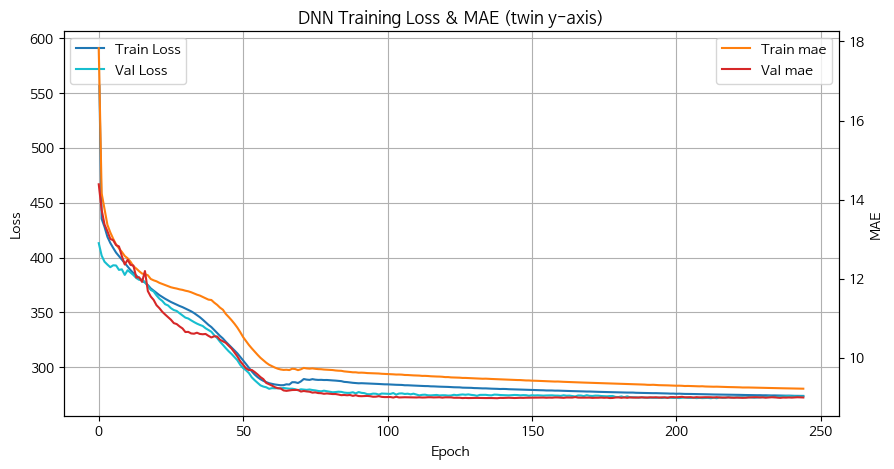

In [49]:
# 학습과정 그래프를 subplots와 twinx로 시각화
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(history.history['loss'], label='Train Loss', color='tab:blue')
ax1.plot(history.history['val_loss'], label='Val Loss', color='tab:cyan')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')
ax1.grid(True)
ax2 = ax1.twinx()
ax2.plot(history.history['mae'], label='Train mae', color='tab:orange')
ax2.plot(history.history['val_mae'], label='Val mae', color='tab:red')
ax2.set_ylabel('MAE')
ax2.legend(loc='upper right')
plt.title('DNN Training Loss & MAE (twin y-axis)')
plt.show()

# 모델 평가

In [50]:
loss_and_mae = model.evaluate(test_X,test_y)
print('loss :',  loss_and_mae[0])
print('mae :',  loss_and_mae[1])

5759/5759 [==============================] - 9s 2ms/step - loss: 289.4613 - mae: 9.7786
loss : 289.4613037109375
mae : 9.778632164001465


In [59]:
print("타겟변수 최대값 : ",df_total["PM대여량"].max())
print("타겟변수 최소값 : ",df_total["PM대여량"].min())
print("타겟변수 평균값 : ",df_total["PM대여량"].mean())
print("타겟변수 표준편차 : ",df_total["PM대여량"].std())
# 타겟변수 대비 mae 오차 수준
print("타겟변수 대비 mae 오차 수준",loss_and_mae[1]/df_total["PM대여량"].mean() * 100, "%" ) # 30 ~ 40% 사이 : 예측값이 10일때, 0 ~ 20의 편차 발생, 부정확한 모델

타겟변수 최대값 :  167
타겟변수 최소값 :  3
타겟변수 평균값 :  28.435073610833772
타겟변수 표준편차 :  24.659611717346884
타겟변수 대비 mae 오차 수준 34.38933303930609 %


# 모델 저장

In [62]:
# 모델, 스케일러, 인코더, feature 리스트 저장
# pm_gu_list : PM운영 행정구
# gu_list : 서울시 전체 행정구
# le_season : 계절 라벨인코더
# le_commute : 출퇴근시간여부 라벨 인코더
# le_gu : 행정구 인코더
# scaler : 독립변수 스케일러 / cols_scale = ['총생활인구수', '강수', '기온','습도','풍속','공공자전거대여량']
import joblib
model.save('M2_DNN.h5')
joblib.dump(pm_gu_list,'M2_ENCODER\PM활용행정구리스트.pkl')
joblib.dump(gu_list, 'M2_ENCODER\서울전역행정구리스트.pkl')
joblib.dump(le_season, 'M2_ENCODER\계절라벨인코더.pkl')
joblib.dump(le_commute, 'M2_ENCODER\출퇴근시간여부라벨인코더.pkl')
joblib.dump(le_gu, 'M2_ENCODER\행정구라벨인코더.pkl')
joblib.dump(cols_scale, 'M2_ENCODER\독립변수리스트.pkl')
joblib.dump(scaler, 'M2_ENCODER\독립변수스케일러.pkl')

['M2_ENCODER\\독립변수스케일러.pkl']

# 모델 사용

In [ ]:
def class_to_range(pred_class):
    # qcut 구간을 이용해서 문자로 반환
    bins = [1, 19, 37, 62, 93, 131, 180, 254, 393, 3258]
    pred_class = int(pred_class)
    left = int(bins[pred_class])
    right = int(bins[pred_class+1]) if pred_class+1 < len(bins) else '+'
    return f"{left} ~ {right}"